In [1]:
pip install aif360

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Importation des librairies nécessaires 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'


In [3]:
#Chargement de notre dataset en tant que DataFrame
df = pd.read_csv('/Users/come/Desktop/ENSAE/Hackathon-Ekimetrics/stackoverflow_full.csv')
df

,Unnamed: 0,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,Country,PreviousSalary,HaveWorkedWith,ComputerSkills,Employed
0,0,<35,No,Master,1,Man,No,Dev,7,4,Sweden,51552.0,C++;Python;Git;PostgreSQL,4,0
1,1,<35,No,Undergraduate,1,Man,No,Dev,12,5,Spain,46482.0,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,12,1
2,2,<35,No,Master,1,Man,No,Dev,15,6,Germany,77290.0,C;C++;Java;Perl;Ruby;Git;Ruby on Rails,7,0
3,3,<35,No,Undergraduate,1,Man,No,Dev,9,6,Canada,46135.0,Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL;Gi...,13,0
4,4,>35,No,PhD,0,Man,No,NotDev,40,30,Singapore,160932.0,C++;Python,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73457,73457,<35,No,Undergraduate,1,Man,No,Dev,7,2,Germany,41058.0,C#;HTML/CSS;JavaScript;TypeScript;Docker;Kuber...,13,1
73458,73458,>35,No,Undergraduate,1,Man,No,Dev,21,16,United States of America,115000.0,C#;HTML/CSS;Java;JavaScript;npm;ASP.NET Core ;...,11,1
73459,73459,<35,No,Undergraduate,1,Man,No,Dev,4,3,Nigeria,57720.0,HTML/CSS;JavaScript;TypeScript;Docker;Express;...,12,1
73460,73460,<35,Yes,Undergraduate,1,Man,Yes,Dev,5,1,United States of America,70000.0,C#;HTML/CSS;JavaScript;SQL;TypeScript;npm;Yarn...,15,1


In [4]:
#Nombre d'observations
nb_obs = df.shape[0]
nb_obs

73462

In [5]:
#Existence de valeurs manquantes 
miss_val = df.isna().any().any()
miss_val

True

In [6]:
#Nombre de valeurs manquantes par colonne 
miss_val_col = df.isna().sum()
miss_val_col

Unnamed: 0         0
Age                0
Accessibility      0
EdLevel            0
Employment         0
Gender             0
MentalHealth       0
MainBranch         0
YearsCode          0
YearsCodePro       0
Country            0
PreviousSalary     0
HaveWorkedWith    63
ComputerSkills     0
Employed           0
dtype: int64

# Statistiques descriptives

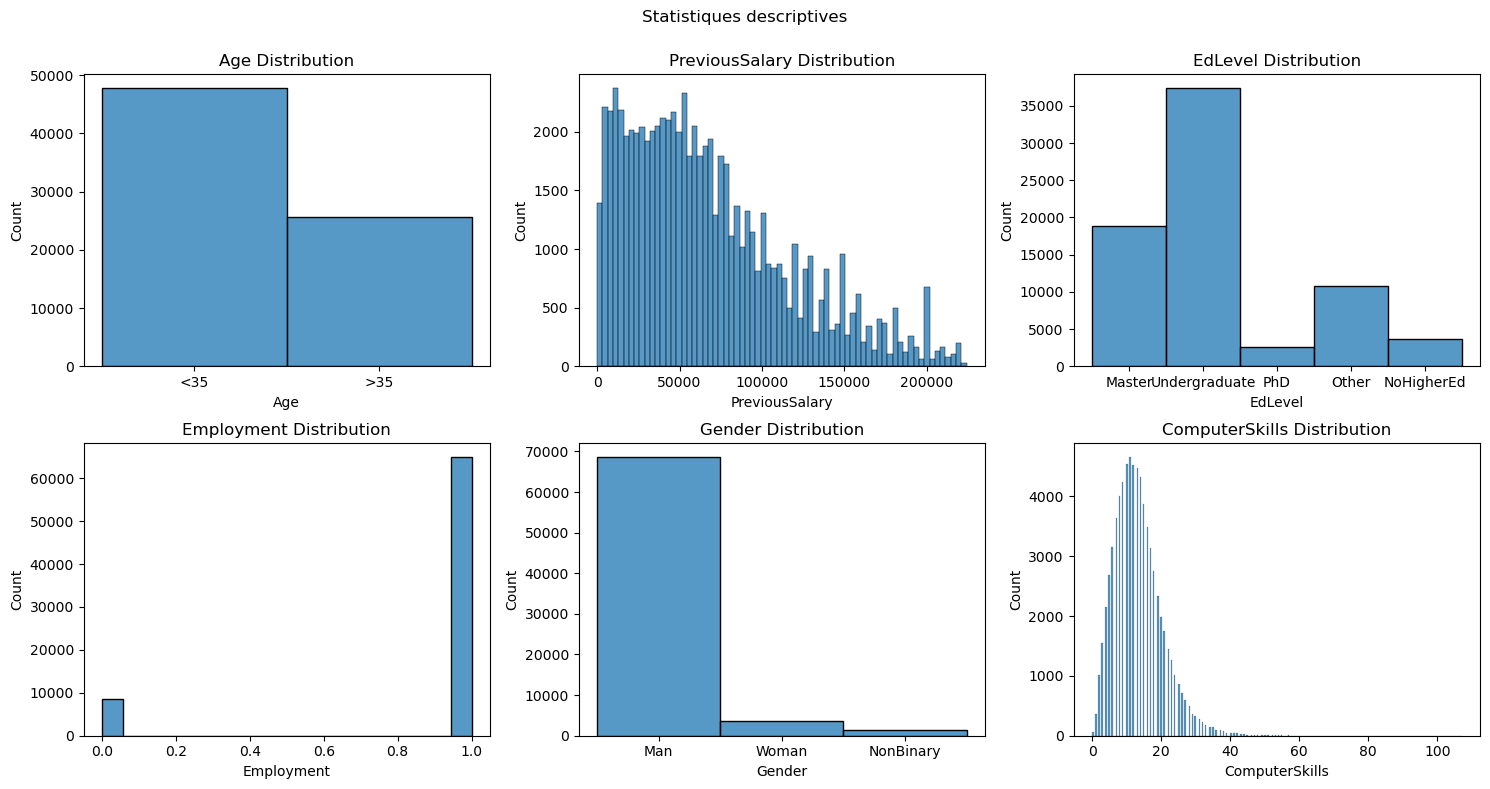

In [7]:
#Variables à inclure dans les statistiques descriptives
variables_to_describe = ['Age', 'PreviousSalary', 'EdLevel', 'Employment', 'Gender', 'ComputerSkills']

#Création d'une grille de sous-graphiques
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
fig.suptitle('Statistiques descriptives')

for i, variable in enumerate(variables_to_describe):
    row, col = i // 3, i % 3
    sns.histplot(data=df, x=variable, ax=axes[row, col], kde=False)
    axes[row, col].set_title(f'{variable} Distribution')

plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()

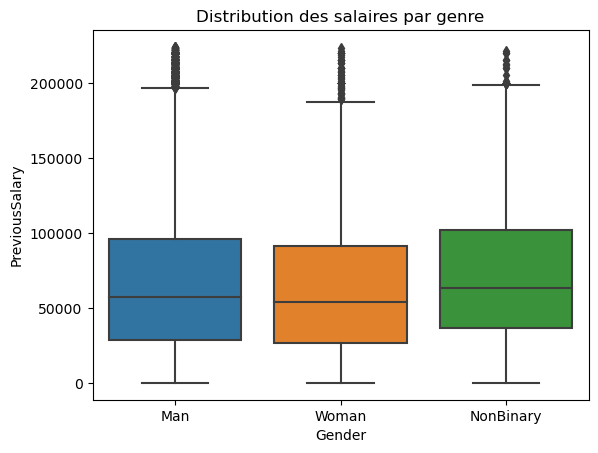

In [8]:
sns.boxplot(x='Gender', y='PreviousSalary', data=df)
plt.title('Distribution des salaires par genre')
plt.show()

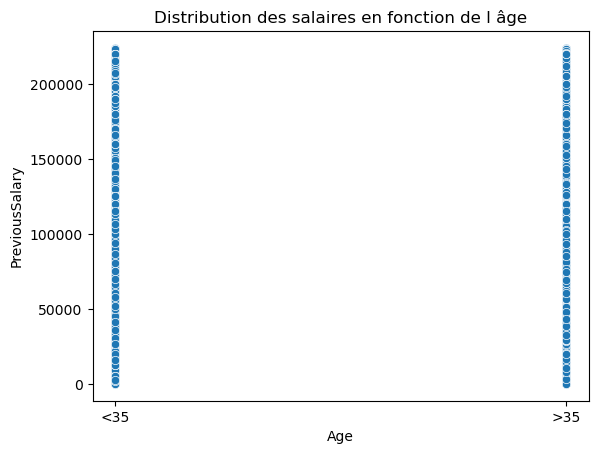

In [9]:
sns.scatterplot(x='Age', y='PreviousSalary', data=df)
plt.title('Distribution des salaires en fonction de l âge')
plt.show()

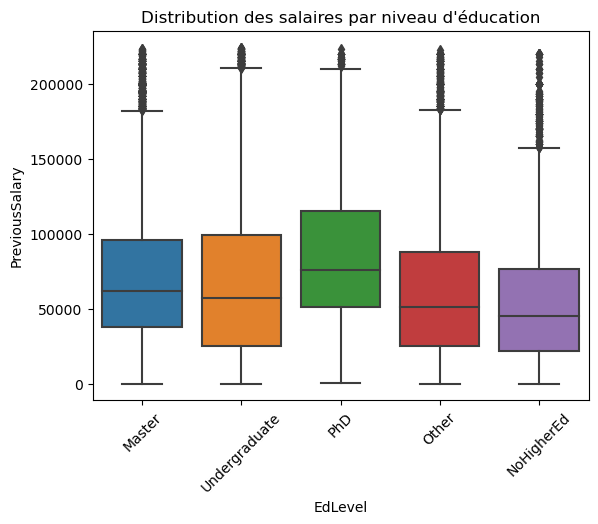

In [10]:
#Distribution des salaires par niveau d'éducation
sns.boxplot(x='EdLevel', y='PreviousSalary', data=df)
plt.title('Distribution des salaires par niveau d\'éducation')
plt.xticks(rotation=45)
plt.show()

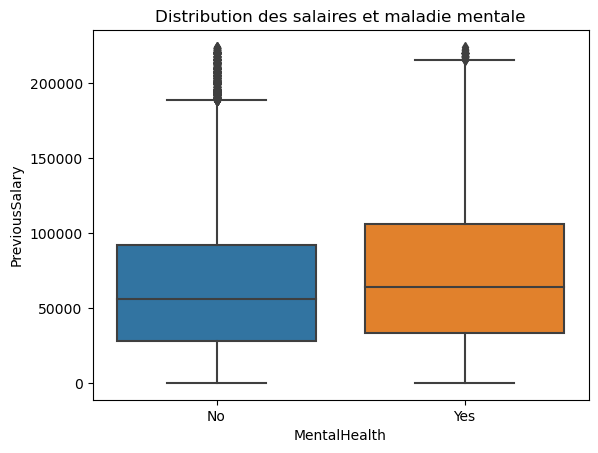

In [11]:
sns.boxplot(x='MentalHealth', y='PreviousSalary', data=df)
plt.title('Distribution des salaires et maladie mentale')
plt.show()

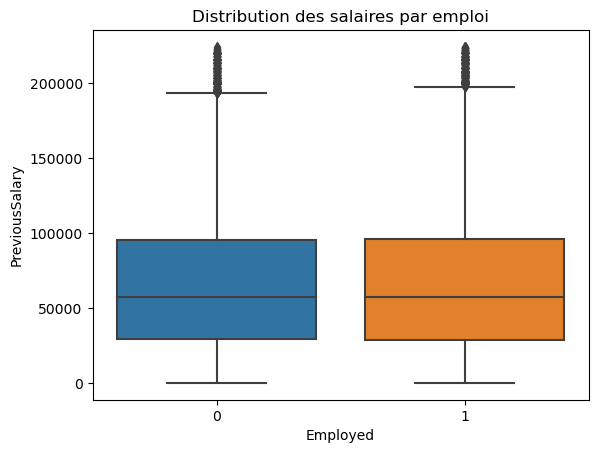

In [12]:
sns.boxplot(x='Employed', y='PreviousSalary', data=df)
plt.title('Distribution des salaires par emploi')
plt.show()

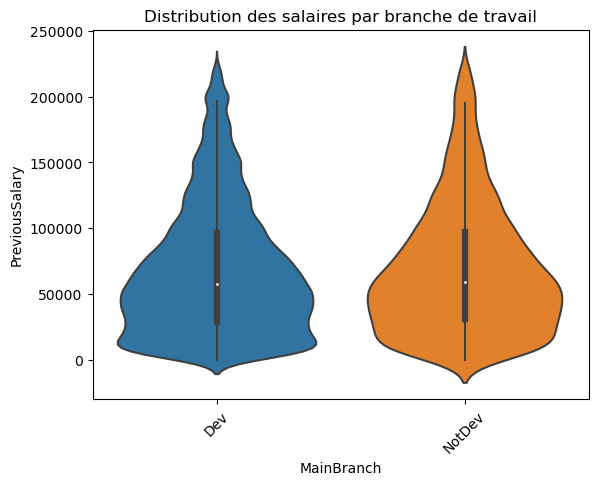

In [13]:
sns.violinplot(x='MainBranch', y='PreviousSalary', data=df)
plt.title('Distribution des salaires par branche de travail')
plt.xticks(rotation=45)
plt.show()


On explore par ailleurs notre variable cible pour vérifier que les 2 catégories ne sont pas trop désquilibrées

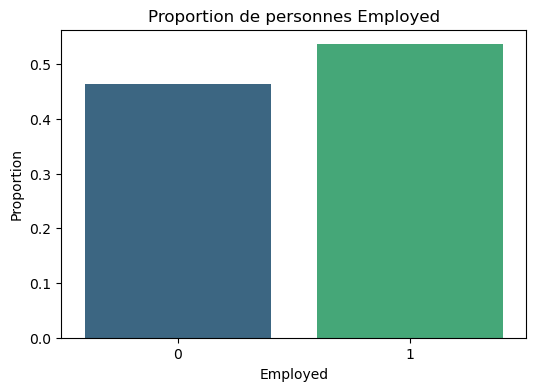

In [14]:
employed_proportion = df['Employed'].value_counts(normalize=True)

#Tracer le graphique
plt.figure(figsize=(6, 4))
sns.barplot(x=employed_proportion.index, y=employed_proportion.values, palette='viridis')
plt.title('Proportion de personnes Employed')
plt.xlabel('Employed')
plt.ylabel('Proportion')
plt.show()

# Identification des biais 

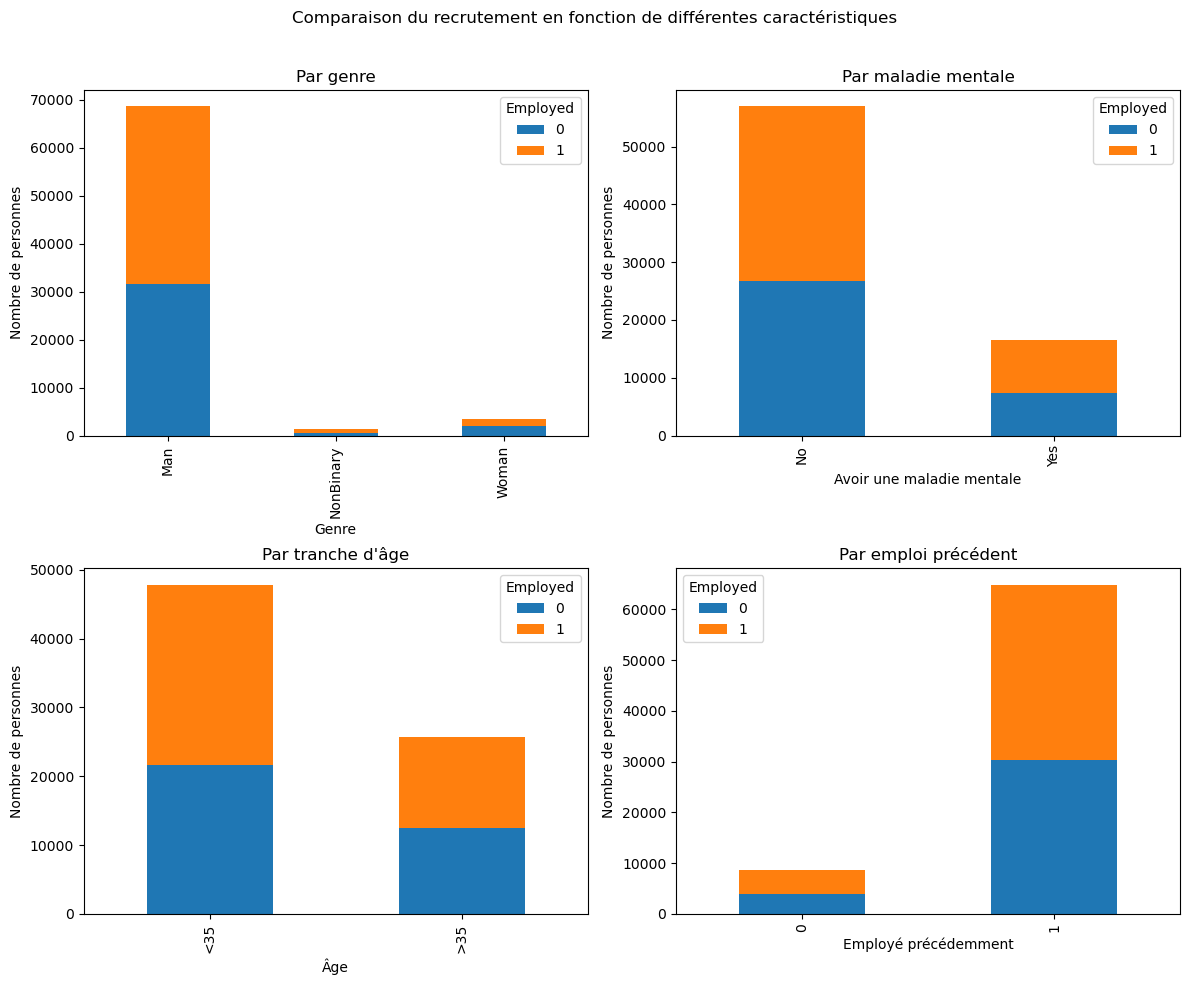

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Comparaison du recrutement en fonction de différentes caractéristiques")

gender_employed = df.groupby(['Gender', 'Employed']).size().unstack()
gender_employed.plot(kind='bar', stacked=True, ax=axes[0, 0])
axes[0, 0].set_title("Par genre")
axes[0, 0].set_ylabel("Nombre de personnes")
axes[0, 0].set_xlabel("Genre")

mental_health_employed = df.groupby(['MentalHealth', 'Employed']).size().unstack()
mental_health_employed.plot(kind='bar', stacked=True, ax=axes[0, 1])
axes[0, 1].set_title("Par maladie mentale")
axes[0, 1].set_ylabel("Nombre de personnes")
axes[0, 1].set_xlabel("Avoir une maladie mentale")

age_employed = df.groupby(['Age', 'Employed']).size().unstack()
age_employed.plot(kind='bar', stacked=True, ax=axes[1, 0])
axes[1, 0].set_title("Par tranche d'âge")
axes[1, 0].set_ylabel("Nombre de personnes")
axes[1, 0].set_xlabel("Âge")

previous_employed = df.groupby(['Employment', 'Employed']).size().unstack()
previous_employed.plot(kind='bar', stacked=True, ax=axes[1, 1])
axes[1, 1].set_title("Par emploi précédent")
axes[1, 1].set_ylabel("Nombre de personnes")
axes[1, 1].set_xlabel("Employé précédemment")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


Pour avoir une idée de s'il y a une présence de biais, il faut comparer les taux de proposition d'emplois en fonction des caractéristiques. En effet, cela risquerait d'être biaisé si l'on prenait en compte la valeur absolue, car certaines variables ont des catégories sur-représentées par rapport à d'autres. 

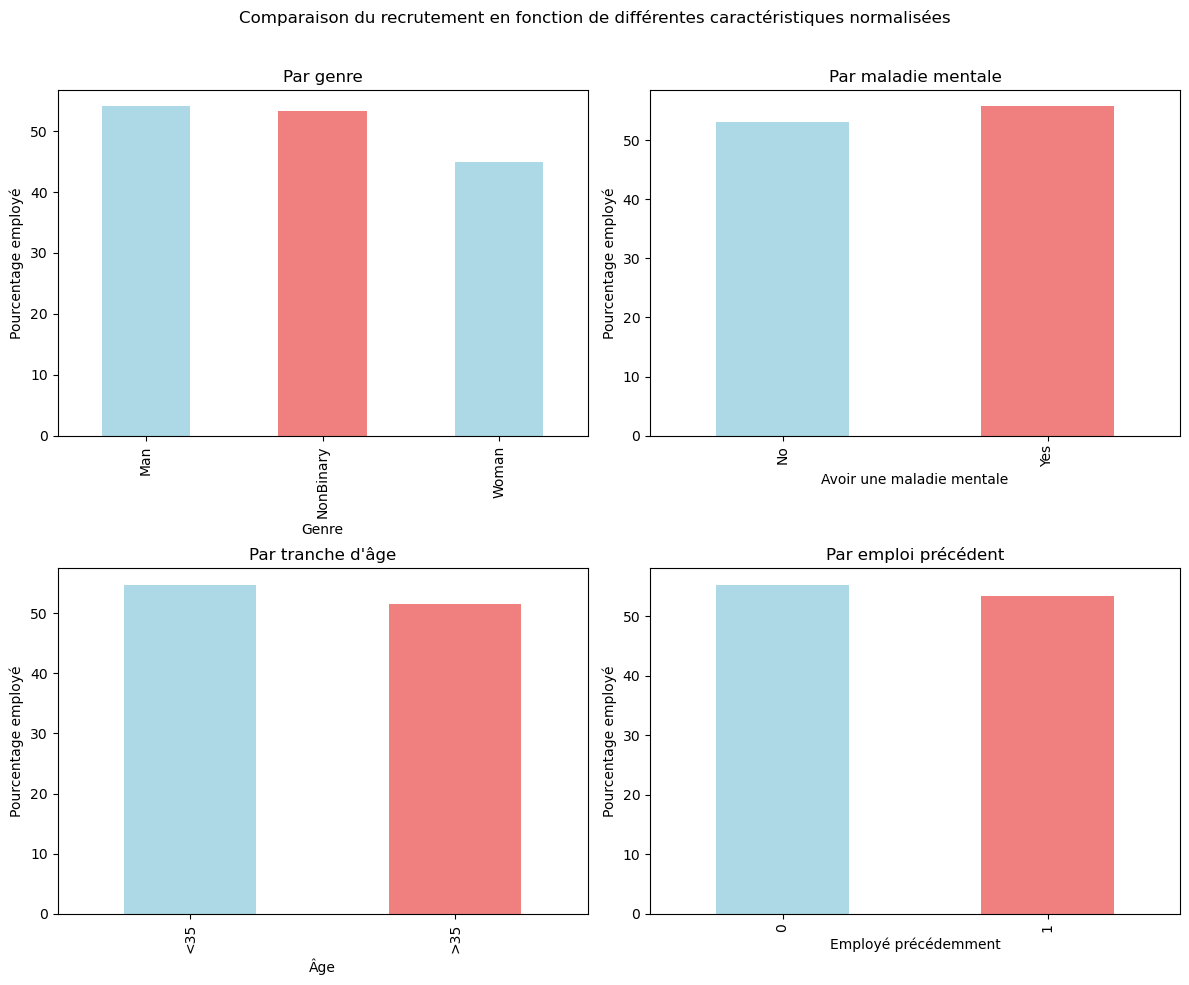

In [16]:
#Calcul des pourcentages par groupe
gender_percentage = df.groupby('Gender')['Employed'].mean() * 100
mental_health_percentage = df.groupby('MentalHealth')['Employed'].mean() * 100
age_percentage = df.groupby('Age')['Employed'].mean() * 100
previous_employed_percentage = df.groupby('Employment')['Employed'].mean() * 100

#Bar charts avec les proportions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Comparaison du recrutement en fonction de différentes caractéristiques normalisées")

gender_percentage.plot(kind='bar', ax=axes[0, 0], color=['lightblue', 'lightcoral'])
axes[0, 0].set_title("Par genre")
axes[0, 0].set_ylabel("Pourcentage employé")
axes[0, 0].set_xlabel("Genre")

mental_health_percentage.plot(kind='bar', ax=axes[0, 1], color=['lightblue', 'lightcoral'])
axes[0, 1].set_title("Par maladie mentale")
axes[0, 1].set_ylabel("Pourcentage employé")
axes[0, 1].set_xlabel("Avoir une maladie mentale")

age_percentage.plot(kind='bar', ax=axes[1, 0], color=['lightblue', 'lightcoral'])
axes[1, 0].set_title("Par tranche d'âge")
axes[1, 0].set_ylabel("Pourcentage employé")
axes[1, 0].set_xlabel("Âge")

previous_employed_percentage.plot(kind='bar', ax=axes[1, 1], color=['lightblue', 'lightcoral'])
axes[1, 1].set_title("Par emploi précédent")
axes[1, 1].set_ylabel("Pourcentage employé")
axes[1, 1].set_xlabel("Employé précédemment")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Modélisation 

### Construction des attributs protégés ###

In [17]:
#Gender
df['Gender_Protected'] = df['Gender']

df['Gender_Protected'] = df['Gender_Protected'].replace({'Man': 'Male', 'Woman': 'Female', 'NonBinary': 'Non-Binary'})

#Age
df['Age_Protected'] = df['Age'].apply(lambda x: 0 if x == '<35' else 1)

#Mental Health
df['MentalHealth_Protected'] = df['MentalHealth']

df['MentalHealth_Protected'] = df['MentalHealth_Protected'].replace({'Yes': 1, 'No': 0})

print(df[['Gender_Protected', 'Age_Protected','MentalHealth_Protected', 'Employed']].head())

  Gender_Protected  Age_Protected  MentalHealth_Protected  Employed
0             Male              0                       0         0
1             Male              0                       0         1
2             Male              0                       0         0
3             Male              0                       0         0
4             Male              1                       0         0


In [18]:
from sklearn.preprocessing import LabelEncoder

categorical_column = 'EdLevel'

#Création du label encoder
label_encoder = LabelEncoder()

df[categorical_column] = label_encoder.fit_transform(df[categorical_column])

In [19]:
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ['MainBranch','Accessibility']

encoder = OneHotEncoder(sparse=False, drop='first')  #'drop' permet d'éviter la co-linéarité

#On applique l'encodage aux colonnes sélectionnées 
encoded_columns = encoder.fit_transform(df[categorical_columns])

#Création d'un dataframe avec les colonnes encodées 
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(categorical_columns))

#Nouveau dataframe
df = df.drop(categorical_columns, axis=1)
df = pd.concat([df, encoded_df], axis=1)

In [20]:
#Sélection de la colonne 'Technologies' (supposons que cette colonne contient les technologies utilisées)
technologies = df['HaveWorkedWith']

#Création des indicateurs binaires (One-Hot Encoding) pour chaque technologie
technologies_encoded = technologies.str.get_dummies(';')

df = pd.concat([df, technologies_encoded], axis=1)

In [21]:
#Création de la nouvelle variable binaire
df['Gender_Protected_ind'] = df['Gender_Protected'].apply(lambda x: 1 if x in ['Male', 'NonBinary'] else 0)

print(df[['Gender_Protected', 'Gender_Protected_ind']].head())

  Gender_Protected  Gender_Protected_ind
0             Male                     1
1             Male                     1
2             Male                     1
3             Male                     1
4             Male                     1


In [22]:
print(list(df.columns))

['Unnamed: 0', 'Age', 'EdLevel', 'Employment', 'Gender', 'MentalHealth', 'YearsCode', 'YearsCodePro', 'Country', 'PreviousSalary', 'HaveWorkedWith', 'ComputerSkills', 'Employed', 'Gender_Protected', 'Age_Protected', 'MentalHealth_Protected', 'MainBranch_NotDev', 'Accessibility_Yes', 'APL', 'ASP.NET', 'ASP.NET Core ', 'AWS', 'Angular', 'Angular.js', 'Ansible', 'Assembly', 'Bash/Shell', 'Blazor', 'C', 'C#', 'C++', 'COBOL', 'Cassandra', 'Chef', 'Clojure', 'Cloud Firestore', 'Colocation', 'CouchDB', 'Couchbase', 'Crystal', 'Dart', 'Delphi', 'Deno', 'DigitalOcean', 'Django', 'Docker', 'Drupal', 'DynamoDB', 'Elasticsearch', 'Elixir', 'Erlang', 'Express', 'F#', 'FastAPI', 'Fastify', 'Firebase', 'Firebase Realtime Database', 'Flask', 'Flow', 'Fortran', 'Gatsby', 'Git', 'Go', 'Google Cloud', 'Google Cloud Platform', 'Groovy', 'HTML/CSS', 'Haskell', 'Heroku', 'Homebrew', 'IBM Cloud or Watson', 'IBM DB2', 'Java', 'JavaScript', 'Julia', 'Kotlin', 'Kubernetes', 'LISP', 'Laravel', 'Linode', 'Lua', '

In [23]:
#Sélection des colonnes nécessaires pour le modèle et les attributs protégés
model_data = df[['EdLevel', 'Employment', 'YearsCode', 'YearsCodePro', 'Country', 'PreviousSalary', 'ComputerSkills', 'Employed', 'Gender_Protected_ind', 'Age_Protected', 'MentalHealth_Protected', 'MainBranch_NotDev', 'Accessibility_Yes', 'APL', 'ASP.NET', 'ASP.NET Core ', 'AWS', 'Angular', 'Angular.js', 'Ansible', 'Assembly', 'Bash/Shell', 'Blazor', 'C', 'C#', 'C++', 'COBOL', 'Cassandra', 'Chef', 'Clojure', 'Cloud Firestore', 'Colocation', 'CouchDB', 'Couchbase', 'Crystal', 'Dart', 'Delphi', 'Deno', 'DigitalOcean', 'Django', 'Docker', 'Drupal', 'DynamoDB', 'Elasticsearch', 'Elixir', 'Erlang', 'Express', 'F#', 'FastAPI', 'Fastify', 'Firebase', 'Firebase Realtime Database', 'Flask', 'Flow', 'Fortran', 'Gatsby', 'Git', 'Go', 'Google Cloud', 'Google Cloud Platform', 'Groovy', 'HTML/CSS', 'Haskell', 'Heroku', 'Homebrew', 'IBM Cloud or Watson', 'IBM DB2', 'Java', 'JavaScript', 'Julia', 'Kotlin', 'Kubernetes', 'LISP', 'Laravel', 'Linode', 'Lua', 'MATLAB', 'Managed Hosting', 'MariaDB', 'Matlab', 'Microsoft Azure', 'Microsoft SQL Server', 'MongoDB', 'MySQL', 'Neo4j', 'Next.js', 'Node.js', 'Nuxt.js', 'OCaml', 'OVH', 'Objective-C', 'OpenStack', 'Oracle', 'Oracle Cloud Infrastructure', 'PHP', 'Perl', 'Phoenix', 'Play Framework', 'PostgreSQL', 'PowerShell', 'Pulumi', 'Puppet', 'Python', 'R', 'React.js', 'Redis', 'Ruby', 'Ruby on Rails', 'Rust', 'SAS', 'SQL', 'SQLite', 'Scala', 'Solidity', 'Spring', 'Svelte', 'Swift', 'Symfony', 'Terraform', 'TypeScript', 'Unity 3D', 'Unreal Engine', 'VBA', 'VMware', 'Vue.js', 'Xamarin', 'Yarn', 'jQuery', 'npm']]

#Création du dataset d'évaluation de l'équité
evaluation_data = model_data[['Employed', 'Gender_Protected_ind', 'Age_Protected', 'MentalHealth_Protected']]

column_to_exclude = ['Country']

X = model_data.drop(['Employed'] + column_to_exclude, axis=1)
y = model_data['Employed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

#Métriques de performance du modèle 
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 0.9794459946913496
Precision: 0.9757263237328638
Recall: 0.9861446548875048
F1 Score: 0.9809078265267418
ROC AUC: 0.9985964841582727


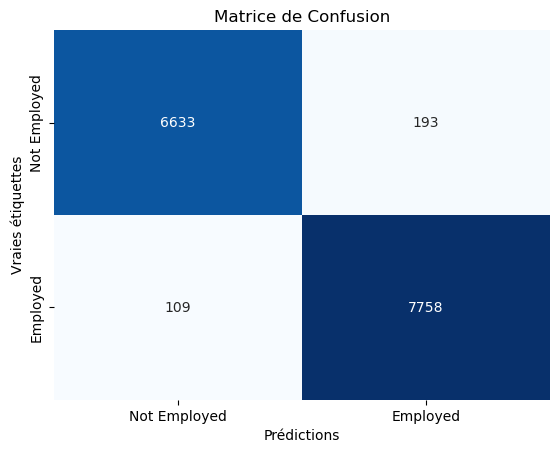

In [25]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Employed', 'Employed'],
            yticklabels=['Not Employed', 'Employed'])
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()


In [26]:
#Création du BinaryLabelDataset pour l'évaluation de l'équité
binary_label_evaluation_dataset = BinaryLabelDataset(df=evaluation_data,
                                                      label_names=['Employed'],
                                                      protected_attribute_names=['Gender_Protected_ind', 'Age_Protected', 'MentalHealth_Protected'])

#Utilisation de BinaryLabelDatasetMetric pour évaluer l'équité
metric = BinaryLabelDatasetMetric(binary_label_evaluation_dataset,
                                   unprivileged_groups=[{'Gender_Protected_ind': 0, 'Age_Protected': 0, 'MentalHealth_Protected': 0}],
                                   privileged_groups=[{'Gender_Protected_ind': 1, 'Age_Protected': 1, 'MentalHealth_Protected': 1}])

#Métriques d'équité
print("Disparate Impact:", metric.disparate_impact())
print("Statistical Parity Difference:", metric.statistical_parity_difference())


Disparate Impact: 0.8865867858073077
Statistical Parity Difference: -0.06063027462624293


# Correction des biais 

### Preprocessing ###

### Inprocessing ###

### Postprocessing ###